## The problem:
### Given any two crude oils with their given distillation profiles, create a model which will give an approximate distillation profile of the mixture of the two oils with specified volumes.   

## STEP 1: INITIALIZATION

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path of the distillation profile and loading data
distillation_profile_path = '.\\crudecomp_all.CSV'

# Names of mixing crude oils
type_a_name = 'Pembina'
type_b_name = 'Secure Sask Light'

# Volume of each crude in percent
volume_type_a = 40
volume_type_b = 100-volume_type_a
assert volume_type_a + volume_type_b == 100

# Check if the file exists
if not os.path.exists(distillation_profile_path):
    raise Exception('{} file does not exist!'.format(distillation_profile_path))
          
# Loading data
distillation_profile_df = pd.read_csv(distillation_profile_path)

profile_headers = distillation_profile_df.columns.values
mass_recovered = profile_headers[0]
crude_oils_names = profile_headers[1:]

# Check if input names of crude oils exist 
if (type_a_name not in crude_oils_names) or (type_b_name not in crude_oils_names):
    raise Exception('Crude oils \"{}\" and/or \"{}\" do not exist!\n Available options are:\n {}'.\
                    format(type_a_name, type_b_name, crude_oils_names))

# PLOT_TYPES is used in plot_xys method
PLOT_TYPES = ['ro', 'bv', 'g^', 'kx', 'cs', 'rv', 'bo', 'gx', 'ks', 'c^']

def plot_xys(xy_s, legends, markers_size, x_label='', y_label='', title='', show=True, grids=False):
    """
    This method is used to simplify data plot.
    :param xy_s: an array of tuples (x,y)'s, i.e., xy_s = [(x1, y1), (x2, y2), ..., (xn, yn)]
    :param legends: an array of corresponding legends (x, y)'s
    :param marker_size: an array of corresponding marker sizes
    :param x_label:
    :param y_label:
    :param title:
    :param show: if True, show the graph
    :return:
    """
    assert len(xy_s) == len(legends) == len(markers_size)
    
    for index, xy in enumerate(xy_s):
        plt.plot(xy[0], xy[1], PLOT_TYPES[index % len(PLOT_TYPES)],  markersize=markers_size[index])
    plt.gca().legend(legends)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if grids:
        plt.grid()
    if show:
        plt.show()

## STEP 2: DATA EXTRACTION, CLEANING, AND VISUALIZATION

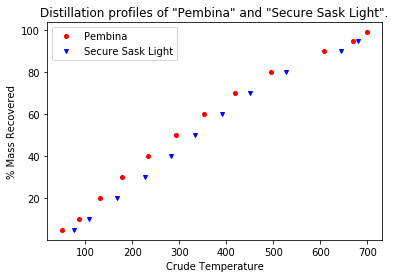

In [2]:
# Remove cells with non-valid characters
invalid_indices_a = distillation_profile_df[type_a_name].isin(['-'])
type_a_column = distillation_profile_df[type_a_name][~invalid_indices_a]
len_a_temperature = len(type_a_column)
assert len_a_temperature != 0

invalid_indices_b = distillation_profile_df[type_b_name].isin(['-'])
type_b_column = distillation_profile_df[type_b_name][~invalid_indices_b]
len_b_temperature = len(type_b_column)
assert len_b_temperature != 0

# Transferring strings to float for each cell
mass_recovered = distillation_profile_df[mass_recovered].apply(lambda x: float(x.split('%')[0]))
temperature_a = type_a_column.apply(lambda x: float(x.split('+')[0]))
temperature_b = type_b_column.apply(lambda x: float(x.split('+')[0]))

# Data visualization to see if further cleaning is required
plot_xys(xy_s=[(temperature_a, mass_recovered[0:len_a_temperature]),
               (temperature_b, mass_recovered[0:len_b_temperature])],
         legends=[type_a_name, type_b_name],
         markers_size=[4, 4],
         x_label='Crude Temperature',
         y_label='% Mass Recovered',
         title='Distillation profiles of \"{}\" and \"{}\".'.format(type_a_name, type_b_name))

## STEP 3: FITTING MODELS TO DATA

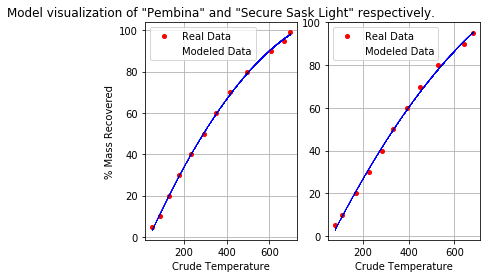

In [7]:
# Fit models (for almost all crude oils, I found polynomials of degree 2 suitable for fitting distillation profiles)
model_a = np.poly1d(np.polyfit(temperature_a, mass_recovered[0:len_a_temperature], 2))
model_b = np.poly1d(np.polyfit(temperature_b, mass_recovered[0:len_b_temperature], 2))

# Model visualization
plt.subplot(1, 2, 1)
dummy_tmprt = list(np.arange(min(temperature_a), max(temperature_a), .01))
plot_xys(xy_s=[(temperature_a, mass_recovered[0:len_a_temperature]), (dummy_tmprt, model_a(dummy_tmprt))],
         legends=['Real Data', 'Modeled Data'],
         markers_size=[4, .01],
         x_label='Crude Temperature',
         y_label='% Mass Recovered',
         title='Model visualization of \"{}\" and \"{}\" respectively.'.format(type_a_name, type_b_name), show=False, grids=True)
plt.subplot(1, 2, 2)
dummy_tmprt = list(np.arange(min(temperature_b), max(temperature_b), .01))
plot_xys(xy_s=[(temperature_b, mass_recovered[0:len_b_temperature]), (dummy_tmprt, model_b(dummy_tmprt))],
         legends=['Real Data', 'Modeled Data'],
         markers_size=[4, .01],
         x_label='Crude Temperature', show=False, grids=True)    

## STEP 4: EXTRACT MASS RECOVERED OF MIXED CRUDE OILS

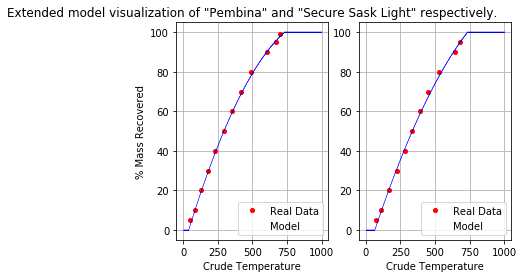

In [4]:
# Extending ranges of models: in order to extract the amount of mass recovered, 
# the predicted models should be extended to a new range as follows:
temperature_range = np.arange(0, 1000, 0.1)
extended_model_a = np.clip(model_a(temperature_range), 0, 100)
extended_model_b = np.clip(model_b(temperature_range), 0, 100)

# Extended model visualization
plt.figure()
plt.subplot(1, 2, 1)
plot_xys(xy_s=[(temperature_a, mass_recovered[0:len_a_temperature]), (temperature_range, extended_model_a)],
         legends=['Real Data', 'Model'],
         markers_size=[4, .01],
         x_label='Crude Temperature',
         y_label='% Mass Recovered',
         title='Extended model visualization of \"{}\" and \"{}\" respectively.'.\
         format(type_a_name, type_b_name), show=False, grids=True)

plt.subplot(1, 2, 2)
plot_xys(xy_s=[(temperature_b, mass_recovered[0:len_b_temperature]), (temperature_range, extended_model_b)],
         legends=['Real Data', 'Model'],
         markers_size=[4, .01],
         x_label='Crude Temperature', show=False, grids=True)

In [5]:
# Here, I assume the amount of mass recovered of two mixed oils 'a' and 'b' follows the following equation
mass_recovered_mixed_model = ((volume_type_a/100) * extended_model_a) + \
                             ((volume_type_b/100) * extended_model_b)

# Extract temperatures of the mixed crude oils corresponding with 5%, 10%, 20%, ..., 99% of mass recovered
distillation_profile_mixed_oils_dct = {}
for mass_recovered_value in mass_recovered.values:
    desired_mass_index = np.where(mass_recovered_mixed_model>=mass_recovered_value)[0][0]
    distillation_profile_mixed_oils_dct[mass_recovered_value] = temperature_range[desired_mass_index]

distillation_profile_mixed_oils = pd.DataFrame(list(distillation_profile_mixed_oils_dct.items()), 
                                                  columns=['Property', 'Mixed Crude Oils'])

print('Distillation profile of %{} of \"{}\" and %{} of \"{}\": \n {}'.\
      format(volume_type_a, type_a_name, volume_type_b, type_b_name, distillation_profile_mixed_oils))

Distillation profile of %40 of "Pembina" and %60 of "Secure Sask Light": 
     Property  Mixed Crude Oils
0        5.0              74.1
1       10.0              98.1
2       20.0             147.8
3       30.0             200.1
4       40.0             255.7
5       50.0             315.0
6       60.0             379.1
7       70.0             449.2
8       80.0             527.6
9       90.0             618.1
10      95.0             670.0
11      99.0             716.4


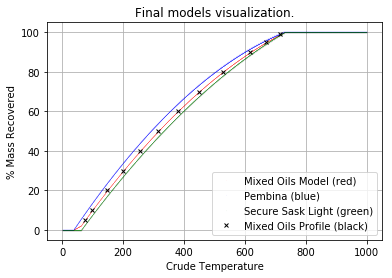

In [6]:
# Visualization of extracted data after blending
plot_xys(xy_s=[(temperature_range, mass_recovered_mixed_model),
               (temperature_range, extended_model_a),
               (temperature_range, extended_model_b), 
               (distillation_profile_mixed_oils['Mixed Crude Oils'], distillation_profile_mixed_oils['Property'])],
        legends=['Mixed Oils Model (red)', type_a_name + ' (blue)', type_b_name + ' (green)', 'Mixed Oils Profile (black)'],
        markers_size=[0.01, .01, .01, 4], x_label='Crude Temperature', y_label='% Mass Recovered',
        title='Final models visualization.', show=False, grids=True)

### Assumptions and simplifications:
- Oils are mixed homogeneously.
- Distillation property of crude in range [0%, 5%] follows the same model as that in range [5%, 99%].
- Distillation property of two mixed oils follows a linear model which is dependent on the corresponding volumes of the mixing crude oils, i.e., at any given temperature 't': <br> mass_recovered_mixed(t) = ( volume_type_a * mass_recovered_a(t) ) +  ( volume_type_b * mass_recovered_b(t) )
